**1. Install Libraries**



In [0]:
#install modules
!pip install lyricsgenius
!pip install textblob
!python -m textblob.download_corpora

**2. Import Packages**

In [0]:
#import packages
from gensim.summarization import keywords
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from spacy.lang.en import English
nlp = English()
nlp.max_length = 10000000
import lyricsgenius
import pandas as pd
from google.colab import files

**3. Define Genius API Authentication**

In [0]:
#define Genius API authentication
genius = lyricsgenius.Genius('your-api-key')

**4. Import Billboard Hot 100 Dataset from Data World**


In [0]:
#import billboard hot100 dataset
hot100_df = pd.read_csv('https://query.data.world/s/qf6et5c7dh23kglnvjcoztlmom62it')
hot100_df.drop_duplicates(subset='SongID', inplace = True) #remove duplicate occurrences of songs
hot100_df.reset_index()

**5. Define Functions**

In [0]:
def get_lyrics(title, artist):
	''' 
	Function to return lyrics of each song using Geniu API
	'''
  try:
    return genius.search_song(title, artist).lyrics
  except:
    return 'not found'

In [0]:
def get_lyric_sentiment(lyrics): 
	''' 
	Function to return sentiment score of each song
	'''
	analysis = TextBlob(lyrics) 
	return analysis.sentiment.polarity

In [0]:
# Function to preprocess text
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

In [0]:
"""Extract Keywords from text"""
def return_keywords(texts):
    xkeywords = []
    values = keywords(text=preprocess(texts),split='\n',scores=True)
    for x in values[:10]:
        xkeywords.append(x[0])
    try:
        return xkeywords 
    except:
        return "no content"

**4. Calculate Lyric Sentiment**

In [0]:
#Use get_lyrics funcion to get lyrics for every song in dataset
lyrics = hot100_df.apply(lambda row: get_lyrics(row['Song'], row['Performer']), axis =1)
hot100_df['Lyrics'] = lyrics
hot100_df = hot100_df.drop(hot100_df[hot100_df['Lyrics'] == 'not found'].index) #drop rows where lyrics are not found on Genius

In [0]:
#Use get_lyric_sentiment to get sentiment score for all the song lyrics
sentiment = hot100_df.apply(lambda row: get_lyric_sentiment(row['Lyrics']), axis =1)
hot100_df['Sentiment'] = sentiment

In [0]:
#Set the index of the dataframe to the WeekID. This sets us up to resample dataframe based on time
hot100_df['WeekID'] = pd.to_datetime(hot100_df['WeekID'],infer_datetime_format=True)
hot100_df = hot100_df.sort_values(by='WeekID')
hot100_df = hot100_df.reset_index(drop=True)
hot100_df = hot100_df.set_index('WeekID')

In [0]:
#Resample dataframe sentiment column by year. This arranges the mean lyric sentiment for every year
hot100_resample = hot100_df['Sentiment'].resample('Y').mean()

**5. Plot Lyric Sentiment Over Time**

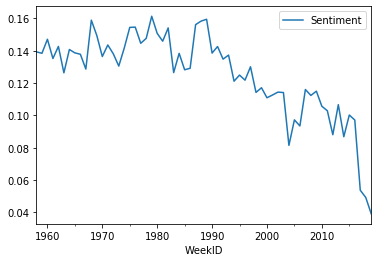

In [0]:
#Plot a line graph of lyric sentiment over time
hot100_resample.plot(label='Sentiment', legend=True)

In [0]:
#Calculate the mean percentage change of lyric sentiment
hot100_resample.pct_change().mean()

-0.012904971574345343

**6. Discover Top Keywords in Lyrics Over Time**

In [0]:
#Resample daraframe lyrics by year. Get all the lyrics for every song for each year
lyrics_resample = hot100_df['Lyrics'].resample('Y').sum()

In [0]:
#Use return_keywords function on lyrics_resample to get the top 20 keywords for each year
lyric_keywords = [return_keywords(x[1]) for x in lyrics_resample.iteritems()]

In [0]:
#Put lyric_keywords into a DataFrame and include lyrics_resample and hot100_resample
keywords_df = pd.DataFrame(lyrics_keywords, columns = ['Keywords'])
keywords_df = keywords_df.set_index(lyrics_resample.index)
keywords_df['Lyrics'] = lyrics_resample
keywords_df['Sentiment'] = hot100_resample